**Bag of words**

Tehnika za modelovanje teksta. Vec smo prosli vektorizaciju teksta. Bag of words je slicna tehnika sa slicnim outputom.

Za BoW se moze reci da je metoda ekstrakcije feature-a iz tekstualnih podataka. Poprilicno je jednostavna i brza metoda, koja je takodje fleksibilna tako da je dobar nacin ekstrakcije feature-a iz dokumenata.

BoW je reprezentacija teksta koja prikazuje koliko su se cesto odredjene reci pojavljivale u tekstu. Samo se cuva broj reci, ignorisu se gramaticki detalji i redosled reci (iz toga razloga naziv Bag).

Problem kod redovnog teksta, kao inputa u neke ML algoritme, jeste sto ti algoritmi preferijaju lepse strukturisane inpute. BoW nam daje nacin da tekstove varijabilnih duzina pretvorimo u vektore fiksnih duzina

In [ ]:
import pandas as pd
import numpy as np
import collections
import re

In [ ]:
sent1 = 'Star Trek is an incredible tv show!'
sent2 = 'Star Trek is the best tv show!'
sent3 = 'Star Trek is so awesome'

Kao sto smo vec prolazili, moramo da uradimo neku formu preprocessinga pre nego sto mozemo da radimo ikakve transformacije. Uklonicemo znakove interpunkcije i tokenizovacemo (jednostavnim splitom)

In [ ]:
sent1_p = re.sub(r'[^a-zA-Z0-9]', ' ', sent1.lower()).split()
sent2_p = re.sub(r'[^a-zA-Z0-9]', ' ', sent2.lower()).split()
sent3_p = re.sub(r'[^a-zA-Z0-9]', ' ', sent3.lower()).split()

wordset = set(sent1_p+sent2_p+sent3_p)

{'show', 'incredible', 'the', 'is', 'awesome', 'an', 'tv', 'trek', 'star', 'best', 'so'}


Sada imamo nacin da definisemo funkciju koja ce da ekstraktuje feature iz svakog "dokumenta" - recenice u ovom slucaju.


*   Prvo cemo definisati recnik sa kljucevima koji odgovara recima u vokabularu - sa vrednoscu 0
*   Proci cemo preko recu koje se nalaze samo u dokumentu i svakoj reci cemo dodeliti frekvenciju


In [ ]:
def calculate_bow(wordset, doc):

  f_dict = dict.fromkeys(wordset, 0)

  for word in doc:

    f_dict[word] = doc.count(word)
  
  return f_dict

In [ ]:
bow1 = calculate_bow(wordset, sent1_p)
bow2 = calculate_bow(wordset, sent2_p)
bow3 = calculate_bow(wordset, sent3_p)

In [ ]:
df_bow = pd.DataFrame([bow1, bow2, bow3])
df_bow.head()

show  incredible  the  is  awesome  an  tv  trek  star  best  so
0     1           1    0   1        0   1   1     1     1     0   0
1     1           0    1   1        0   0   1     1     1     1   0
2     0           0    0   1        1   0   0     1     1     0   1

Sada cemo opet iskoristiti vec pokriveni countvectorizer i videcemo da dobijamo isti output.

Count vectorizer ce nam dozvoliti da uradimo jos neke dodatne transformacije bez da gubimo vreme i sami ih implementiramo.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()

vectorizer.fit([sent1, sent2, sent3])

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())

{'star': 7, 'trek': 9, 'is': 4, 'an': 0, 'incredible': 3, 'tv': 10, 'show': 5, 'the': 8, 'best': 2, 'so': 6, 'awesome': 1}
['an' 'awesome' 'best' 'incredible' 'is' 'show' 'so' 'star' 'the' 'trek'
 'tv']


In [ ]:
dtm = vectorizer.fit_transform([sent1, sent2, sent3])

df_bow_sklearn = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head()

an  awesome  best  incredible  is  show  so  star  the  trek  tv
0   1        0     0           1   1     1   0     1    0     1   1
1   0        0     1           0   1     1   0     1    1     1   1
2   0        1     0           0   1     0   1     1    0     1   0

Primetili smo da nismo uklanjali stop reci u preprocessingu. Mozemo ih ukloniti pomocu sklearna

In [ ]:
vectorizer = CountVectorizer(stop_words='english')

dtm = vectorizer.fit_transform([sent1, sent2, sent3])

df_bow_sklearn = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head()

awesome  best  incredible  star  trek  tv
0        0     0           1     1     1   1
1        0     1           0     1     1   1
2        1     0           0     1     1   0

Kao sto smo vec spominjali u nekim slucajevima individualne reci nemaju toliku tezinu kao kada ih spojimo sa recima koje idu uz njih. Ovakve forme mozemo definisati bigramima (tv show na primer)

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))

dtm = vectorizer.fit_transform([sent1, sent2, sent3])

df_bow_sklearn = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head()

best tv  incredible tv  star trek  trek awesome  trek best  trek incredible
0        0              1          1             0          0                1
1        1              0          1             0          1                0
2        0              0          1             1          0                0

**TF-IDF - term frequency - inverse document frequency**

Prethodno opisan metod uzima broj ponavljanja svake reci i predstavlja ga u vektoru.

Visok broj ponavljanja ne mora nuzno da znaci da je rec relevantna  za opis dokumenta. Moze jednostavno da bude frekventna rec koja se generalno koristi, a ne zato sto je relevantna ili znacajna za tekst.

Da bismo taj problem resili imamo nekoliko pristupa.

Mozemo reskalirati frekvenciju reci po tome koliko cesto se pojavljuju u svim dokumentima, tako da ce neke frekventne reci koje nisu stop reci, biti "kaznjene". Ovakav pristup se naziva TF-IDF. Sluzi da bi detaljnije opisao koliko je neki termin relevantan za dataset.

Racuna se tako sto se mnoze dve razlicite metrike: TF i IDF

TF - broj ponavljanja reci u dokumentu. Imamo nekoliko nacina za racunanje. Generalna formula je sledeca:


> TF(i, j) = n(i,j)/sum(n(i,j))

Gde su:

n(i,j) - broj puta koliko se n-ta rec pojavila u dokumentu
sum(n(i,j)) - ukupan broj reci u dokumentu


IDF - broj ponavljanja reci u nekom setu dokumenata. Ovo pokazuje koliko je rec retka ili cesta unutar celog seta dokumenata. Sto je bliza nuli, to je frekventnija. Moze se izracunati na sledeci nacin:


> IDF = 1+log(N/dN)

Gde su:

N - ukupan broj dokumenata u datasetu
dN = ukupan broj dokumenata u kojima se n-ta rec pojavljuje
Jedinica se dodaje u formulu da bi 0 IDF termini ostali prisutni - ovaj proces se naziva IDF smoothing

I na kraju TF-IDF dobijamo tako sto:



> TF_IDF = TF*IDF

Sklearn ima implementaciju ove metode







In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
sent_1 = "This is a good book. I will read it all the way through."
sent_2 = "This is not good at all."

In [ ]:
#bez smoothovanja IDF - dakle bez jedinice u formuli

tf_idf_vec = TfidfVectorizer(use_idf=True, smooth_idf=False, ngram_range=(1,1), stop_words='english')

tf_idf_data = tf_idf_vec.fit_transform([sent_1, sent_2])

In [ ]:
tf_idf_dataframe = pd.DataFrame(tf_idf_data.toarray(), columns=tf_idf_vec.get_feature_names_out())
tf_idf_dataframe

book      good      read       way
0  0.546454  0.322745  0.546454  0.546454
1  0.000000  1.000000  0.000000  0.000000

In [ ]:
tf_idf_vec_smooth = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,1), stop_words='english')
tf_idf_data_smooth = tf_idf_vec_smooth.fit_transform([sent_1, sent_2])

In [ ]:
tf_idf_dataframe_smooth = pd.DataFrame(tf_idf_data_smooth.toarray(), columns=tf_idf_vec_smooth.get_feature_names_out())
tf_idf_dataframe_smooth

book      good      read       way
0  0.534046  0.379978  0.534046  0.534046
1  0.000000  1.000000  0.000000  0.000000

Iako su BoW modeli jako efikasni i laki za implementaciju imaju nekoliko problema:



1.   Model ignorise lokaciju reci u konstrukciji - slucajevi gde imamo dva ista seta reci sa razlicitim znacenjem su potpuno iste reprezentacije u BoW modelu
2.   BoW ne predstavlja semantiku reci. Dakle slicne reci koje se koriste za isti kontekst mogu da vracaju potpuno razlicite vektore
3.   Model je ogranicen njegovim vokabularom i samo ce ignorisati reci sa kojima nije upoznat



**Continuous bag of words**

Word2vec su grupa modela koji se koriste za kreiranje word embeddinga. Ovi modeli su veoma bazicne neuronske mreze sa dva sloja koje se treniraju da rekonstruisu lingvisticke kontekste reci. Word2vec uzima veliki korpus kao input i vraca vektor prostor, obicno nekoliko stotina dimenzija, gde svaka rec u korpusu dobija svoj vektor u tom prostoru. Dakle za razliku od BoW modela koji ne cuva takve veze, ovi vektori reci su pozicionirani u vektorskom prostoru tako da reci koje dele kontekst i znacenje se nalaze blize jedna drugoj.

CBoW koristi te embedinge da trenira neuronsku mrezu gde se dobija kontekst od nekoliko reci za bilo koje prosledjene target reci. Npr. mozemo da iskoristimo reci "ptica" i "grana" kao kontekstne reci za glagol "sedi" kao target rec.

Arhitektura mreze je jednostavna, i sastoji se od:

- IDX - word embedding kao iinput
- Linearni model kao sakriveni sloj
- Log softmax kao output

In [ ]:
#primer korpusa preuzet sa interneta zbog proverenog outputa
dataset_corpus = """We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with out spells."""

Prvo radimo preprocessing

In [ ]:
sentences = re.sub('[A-Za-z0-9]+', ' ', dataset_corpus)
#uklanja reci od jednog slova
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', dataset_corpus).strip()

sentences = sentences.lower()

In [ ]:
words = sentences.split()
vocabulary = set(words)

In [ ]:
vocab_size = len(vocabulary)
embed_dimension = 10
context_size = 2

In [ ]:
word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for i, word in enumerate(vocabulary)}

sada konstruisemo data-bag u formatu data - [(context), target_word]

In [ ]:
data = []

for i in range(2, len(words)-2):
  context = [words[i-2], words[i-1], words[i+1], words[i+2]]
  target = words[i]
  data.append((context, target))

print(data[:3])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study')]


In [ ]:
import numpy as np

In [ ]:
embeddings = np.random.random_sample((vocab_size, embed_dimension))

In [ ]:
def linear(m, theta):

  w = theta
  return m.dot(w)

def log_softmax(x):

  e_x = np.exp(x - np.max(x))
  return np.log(e_x / e_x.sum())

def NLLLoss(logs, targets):
  out = logs[range(len(targets)), targets]
  return -out.sum()/len(out)

def log_softmax_crossentropy_with_logits(logits, target):

  out = np.zeros_like(logits)
  out[np.arange(len(logits)), target] = 1

  softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

  return (-out + softmax) / logits.shape[0]

In [ ]:
def forward(context_idxs, theta):

  m = embeddings[context_idxs].reshape(1, -1)
  n = linear(m, theta)
  o = log_softmax(n)

  return m, n, o

In [ ]:
def backward(preds, theta, target_idxs):

  m, n, o = preds

  dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
  dw = m.T.dot(dlog)

  return dw

In [ ]:
def optimize(theta, grad, lr=0.03):

  theta -= grad * lr
  return theta

In [ ]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dimension, vocab_size))

In [ ]:
epoch_losses = {}

for epoch in range(80):

  losses = []

  for context, target in data:

    context_idxs = np.array([word_to_index[w] for w in context])
    preds = forward(context_idxs, theta)

    target_idxs = np.array([word_to_index[target]])
    loss = NLLLoss(preds[-1], target_idxs)

    losses.append(loss)

    grad = backward(preds, theta, target_idxs)
    theta = optimize(theta, grad, lr=0.03)

  epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

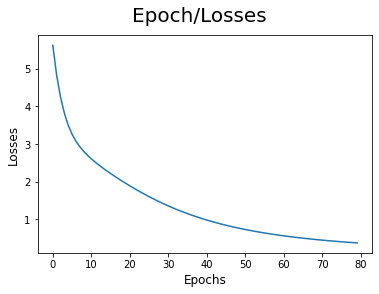

In [ ]:
from matplotlib import pyplot as plt

ix = np.arange(0, 80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [ ]:
def predict(words):

  context_idxs = np.array([word_to_index[w] for w in words])
  preds = forward(context_idxs, theta)
  word = index_to_word[np.argmax(preds[-1])]

  return word

In [ ]:
predict(['we', 'are', 'to', 'study'])

'about'